Student: Luiz Augusto Facury de Souza

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette='colorblind')

5


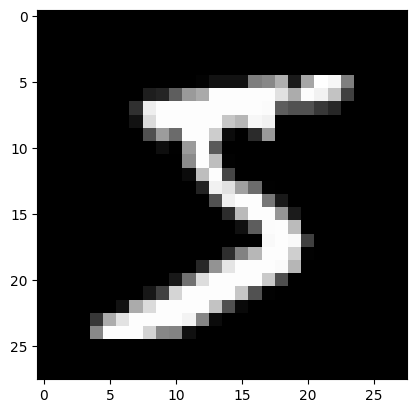

In [498]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]
x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

# Question 4

In [175]:
# source: https://keras.io/guides/training_with_built_in_methods/

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#def loss(true, pred):
#    val = 0.
#    for i in range(len(true)):
#        val -= np.log(pred[i, true[i]])
#    return val / len(true)
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


4.1) As we can see above, we are going to train 26506 parameters:

1)First Layer Weights: 28 * 28 * 32 = 25088

First Layer Bias: 32 (one for each neuron)

Total - 25120

2)Second Layer: 32 * 32 + 32 = 1056

3)Third Layer: 32 * 10 + 10 = 330

Total - 26506

In [176]:
# untrained model
logits = model(x_train)
np.argmax(logits, 1)[0:100]

array([3, 3, 5, 3, 5, 5, 5, 1, 5, 1, 1, 4, 5, 1, 5, 1, 1, 6, 5, 6, 5, 1,
       1, 3, 5, 1, 5, 1, 5, 1, 4, 1, 1, 3, 5, 4, 5, 3, 3, 3, 1, 8, 9, 5,
       3, 5, 1, 9, 1, 1, 1, 3, 9, 1, 6, 1, 3, 9, 5, 3, 6, 3, 8, 3, 1, 3,
       5, 3, 5, 5, 1, 1, 1, 1, 5, 1, 5, 3, 1, 1, 1, 3, 1, 1, 1, 5, 5, 1,
       1, 1, 1, 6, 3, 1, 7, 1, 5, 6, 5, 3])

In [177]:
# what we would like to get
y_train[0:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

# Question 5

In [262]:
## Computing a stochastic gradient

# Source: https://keras.io/guides/writing_a_training_loop_from_scratch/

# Example of gradient computation using automatic differentiation

x_train_batch = x_train[:8]
y_train_batch = y_train[:8]
with tf.GradientTape() as tape:
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        logits = model(x_train_batch)  # Logits for this minibatch

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights)

## Updating weights

def update_weights(model, update):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + update[i]
    model.set_weights(new_weights)


## Evaluate model
samples_for_evaluation = np.random.randint(0, 500, 100)
logits = model(x_train[samples_for_evaluation])
loss(y_train[samples_for_evaluation], logits).numpy()
    

2.3589904

In [431]:
def update_weights(model, update, lr):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] - update[i] * lr
    model.set_weights(new_weights)

5.1)The following function is used to train with GD, I already implemented with the option of setting the batch size, so for SGD we just need to set the batch size to 1.

In [634]:
import tqdm
def train_model_sgd(model, x_train, y_train, loss, learning_rate=0.0001, batch_size=1, epochs=3):
    all_loss = []
    for epoch in tqdm.tqdm(range(epochs)):
        print("Epoch", epoch)
        for i in range(0, len(x_train), batch_size):
            x_train_batch = x_train[i:i+batch_size]
            y_train_batch = y_train[i:i+batch_size]
            with tf.GradientTape() as tape:
                logits = model(x_train_batch)
                loss_value = loss(y_train_batch, logits)
            if (i % 50 == 0):
                all_loss.append(loss_value)
            grad = tape.gradient(loss_value, model.trainable_weights)
            update_weights(model, grad, learning_rate)

    plt.figure(figsize=(12,5))
    plt.plot (all_loss)
    return model



5.2)Using SGD, we need to set the learning rate between 0 and 1. Since the weights are updated after each sample, the learning rate should be small enough to avoid overshooting the minimum. If the learning rate is too small, the training will take a long time to converge. Therefore, it should be chosen in a way that the training converges in a reasonable time, but it can't be too high.

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0


100%|██████████| 1/1 [04:34<00:00, 274.73s/it]


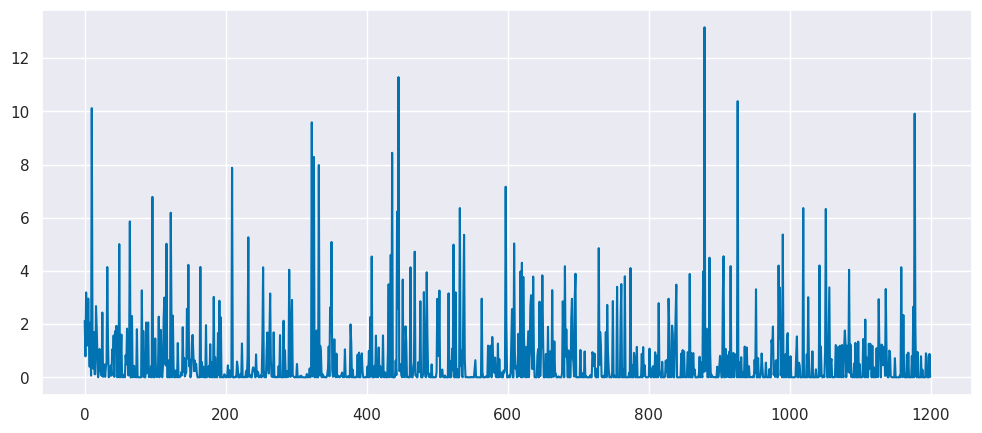

In [650]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
mod = train_model_sgd(model, x_train, y_train, loss, learning_rate=0.05, batch_size=1, epochs=1)

# Question 6

6.1) If we train the SGD with 10 epochs, we can use a lower learning rate, we will have more time to converge.

In [653]:
#Modifying the function to plot per epoch
def train_model_sgd(model, x_train, y_train, loss, learning_rate=0.0001, batch_size=1, epochs=3):
    all_loss = []
    for epoch in tqdm.tqdm(range(epochs)):
        print("Epoch", epoch)
        for i in range(0, len(x_train), batch_size):
            x_train_batch = x_train[i:i+batch_size]
            y_train_batch = y_train[i:i+batch_size]
            with tf.GradientTape() as tape:
                logits = model(x_train_batch)
                loss_value = loss(y_train_batch, logits)

            grad = tape.gradient(loss_value, model.trainable_weights)
            update_weights(model, grad, learning_rate)
        all_loss.append(loss_value)
    plt.figure(figsize=(12,5))
    plt.plot (all_loss)
    return model



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0


 10%|█         | 1/10 [01:25<12:46, 85.13s/it]

Epoch 1


 20%|██        | 2/10 [02:45<10:58, 82.35s/it]

Epoch 2


 30%|███       | 3/10 [04:05<09:29, 81.43s/it]

Epoch 3


 40%|████      | 4/10 [05:26<08:05, 80.96s/it]

Epoch 4


 50%|█████     | 5/10 [06:46<06:43, 80.78s/it]

Epoch 5


 60%|██████    | 6/10 [08:07<05:23, 80.91s/it]

Epoch 6


 70%|███████   | 7/10 [09:30<04:04, 81.38s/it]

Epoch 7


 80%|████████  | 8/10 [10:56<02:46, 83.14s/it]

Epoch 8


 90%|█████████ | 9/10 [12:24<01:24, 84.54s/it]

Epoch 9


100%|██████████| 10/10 [13:38<00:00, 81.88s/it]


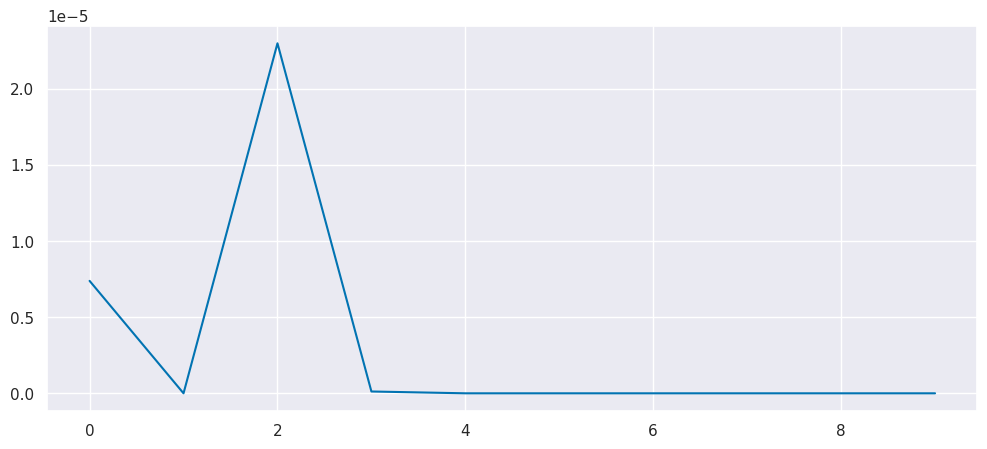

In [655]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
mod = train_model_sgd(model, x_train[::3], y_train[::3], loss, learning_rate=0.02, batch_size=1, epochs=10)

6.2) Using the mini-batch GD, the updates are done after each batch, instead of each sample. This way, the update is more accurate, since it "accumulates" the gradient of the batch. Therefore, the convergence of the training loss is faster in comparison to SGD. 

6.3) was already done

# Question 7

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 0


  7%|▋         | 1/15 [00:05<01:18,  5.57s/it]

Epoch 1


 13%|█▎        | 2/15 [00:10<01:09,  5.36s/it]

Epoch 2


 20%|██        | 3/15 [00:16<01:04,  5.38s/it]

Epoch 3


 27%|██▋       | 4/15 [00:21<00:58,  5.32s/it]

Epoch 4


 33%|███▎      | 5/15 [00:26<00:52,  5.27s/it]

Epoch 5


 40%|████      | 6/15 [00:31<00:46,  5.20s/it]

Epoch 6


 47%|████▋     | 7/15 [00:36<00:41,  5.19s/it]

Epoch 7


 53%|█████▎    | 8/15 [00:41<00:36,  5.17s/it]

Epoch 8


 60%|██████    | 9/15 [00:47<00:31,  5.24s/it]

Epoch 9


 67%|██████▋   | 10/15 [00:52<00:26,  5.22s/it]

Epoch 10


 73%|███████▎  | 11/15 [00:57<00:20,  5.20s/it]

Epoch 11


 80%|████████  | 12/15 [01:03<00:15,  5.29s/it]

Epoch 12


 87%|████████▋ | 13/15 [01:08<00:10,  5.21s/it]

Epoch 13


 93%|█████████▎| 14/15 [01:13<00:05,  5.24s/it]

Epoch 14


100%|██████████| 15/15 [01:18<00:00,  5.24s/it]


Train accuracy: 0.9781
Test accuracy: 0.9667


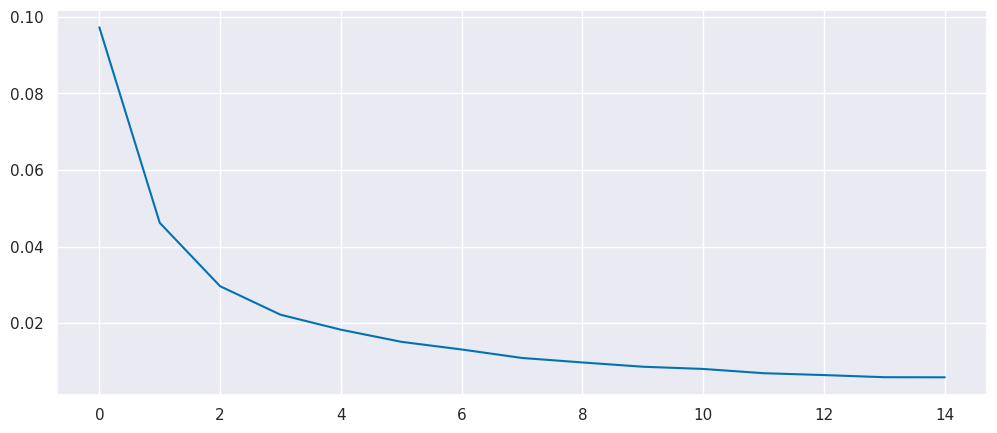

In [654]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs)
x = layers.Dense(32, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation=None, name="predictions")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
mod = train_model_sgd(model, x_train, y_train, loss, learning_rate=0.05, batch_size=64, epochs=15)
yhat_train = np.argmax(mod(x_train), 1)
yhat_test = np.argmax(mod(x_test), 1)
print("Train accuracy:", np.mean(yhat_train == y_train))
print("Test accuracy:", np.mean(yhat_test == y_test))